# **L&T EduTech Hackathon at SHAASTRA IITM**

Here we will try to find optimum training data in percentage with the help of pretrained model that we selected earlier. The judging metric is Cohen Kappa score. 

### Kappa Score:
Cohen’s kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.

More on Cohen kappa score can be found [here](https://towardsdatascience.com/cohens-kappa-9786ceceab58).

In [12]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras import layers
import keras.backend as K
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input


from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

!pip install opendatasets
import opendatasets as od

In [13]:
#od.download('https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/code')

In [14]:
dataset_path = r'/kaggle/input/game-of-deep-learning-ship-datasets'  # main data folder path
train_path = os.path.join(dataset_path, 'train')
images_path = os.path.join(train_path, 'images')
test_csv = os.path.join(dataset_path, 'test_ApKoW4T.csv')
train_csv = os.path.join(train_path, 'train.csv')

test_df = pd.read_csv(test_csv)
train_df = pd.read_csv(train_csv) # it contains image names and their respective labels

num_test_img = len(test_df)
num_train_img = len(train_df)

print(f'Total Number of test images: {num_test_img}')
print(f'Total Number of train images: {num_train_img}')

Total Number of test images: 2680
Total Number of train images: 6252


In [15]:
main_path = "/kaggle/input/game-of-deep-learning-ship-datasets/train/images/"   # it contains all the images
main_df = pd.read_csv(r'/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv')
paths = os.listdir(main_path)
main_df['path'] = main_path + main_df['image']    # In the path column, paths of all images saved.

categories = list(main_df['category'])   # Saves list of ship categories.
categorys = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}

In [16]:
classes = []
for category in categories:
    classes.append(categorys[category])         # Ship category is saved in classes sequencially.


main_df['classes'] = classes
test_df = pd.read_csv(r'/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
test_df['path'] = main_path + test_df['image']

In [17]:
widths, heights = [], []

for path in tqdm(main_df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
main_df["width"] = widths
main_df["height"] = heights
main_df["dimension"] = main_df["width"] * main_df["height"]

100%|██████████| 6252/6252 [00:07<00:00, 870.45it/s]


In [18]:
X, y = main_df[['path', 'classes']], main_df['classes']

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # 10% test and validation data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)  # 5% test data and 5% validation data

In [19]:
datagen = ImageDataGenerator(rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 

val_generator = datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator = datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
)

Found 313 validated image filenames belonging to 5 classes.
Found 313 validated image filenames belonging to 5 classes.


In [20]:
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
IMG_SHAPE = (224,224,3)
xception_model = Xception(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

In [21]:
test_size1 = [0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
from keras.models import load_model

kappa_score = {}
saved_models = ['model10.h5','model20.h5','model30.h5','model40.h5','model50.h5','model60.h5','model70.h5','model80.h5']
X_train = {}
X_v = {}
y_train= {}
y_v = {}
for i in range(len(test_size1)):
    X_train[i], X_v[i], y_train[i], y_v[i] = train_test_split(X_data, y_data, test_size= test_size1[i]/0.9, random_state=42)
  
    train_generator = datagen.flow_from_dataframe(
        X_train[i],  # This is the source directory for training images
        x_col='path',
        y_col='classes',
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        )

    model_xception = tf.keras.Sequential([
    xception_model,
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),    
    tf.keras.layers.Dense(5, activation='softmax')
  ])

    model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    history_xception = model_xception.fit(
      train_generator,
      validation_data=val_generator,
      epochs=20,
      verbose=2)

    model_xception.save(saved_models[i])

    y_pred = model_xception.predict(test_generator)

    y_pred_classes = np.argmax(y_pred, axis = 1)
    print("\nAccuracy:",metrics.accuracy_score(test_generator.labels, y_pred_classes))
    print('\nF1 Score is',f1_score(test_generator.labels, y_pred_classes, average='weighted'))
    kappa_score[i] = cohen_kappa_score(test_generator.labels, y_pred_classes)
    print('\nCohen Kappa Score is\n ',kappa_score[i])

Found 625 validated image filenames belonging to 5 classes.
Epoch 1/20
20/20 - 23s - loss: 1.2687 - accuracy: 0.5104 - val_loss: 2.7671 - val_accuracy: 0.3738
Epoch 2/20
20/20 - 19s - loss: 0.5425 - accuracy: 0.7920 - val_loss: 1.2313 - val_accuracy: 0.6358
Epoch 3/20
20/20 - 19s - loss: 0.3127 - accuracy: 0.8880 - val_loss: 1.2375 - val_accuracy: 0.7029
Epoch 4/20
20/20 - 18s - loss: 0.1881 - accuracy: 0.9344 - val_loss: 1.2713 - val_accuracy: 0.7220
Epoch 5/20
20/20 - 19s - loss: 0.1474 - accuracy: 0.9504 - val_loss: 0.7570 - val_accuracy: 0.8339
Epoch 6/20
20/20 - 18s - loss: 0.0926 - accuracy: 0.9696 - val_loss: 0.8170 - val_accuracy: 0.8115
Epoch 7/20
20/20 - 18s - loss: 0.1076 - accuracy: 0.9584 - val_loss: 0.7749 - val_accuracy: 0.8243
Epoch 8/20
20/20 - 20s - loss: 0.1062 - accuracy: 0.9632 - val_loss: 1.0628 - val_accuracy: 0.7796
Epoch 9/20
20/20 - 18s - loss: 0.0558 - accuracy: 0.9776 - val_loss: 0.6611 - val_accuracy: 0.8403
Epoch 10/20
20/20 - 18s - loss: 0.0504 - accuracy

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.8913738019169329

F1 Score is 0.8898976254185724

Cohen Kappa Score is
  0.8598851906467242
Found 1875 validated image filenames belonging to 5 classes.
Epoch 1/20
59/59 - 51s - loss: 0.2006 - accuracy: 0.9424 - val_loss: 0.4068 - val_accuracy: 0.8914
Epoch 2/20
59/59 - 45s - loss: 0.0759 - accuracy: 0.9744 - val_loss: 0.4615 - val_accuracy: 0.9042
Epoch 3/20
59/59 - 44s - loss: 0.0529 - accuracy: 0.9813 - val_loss: 0.4544 - val_accuracy: 0.9010
Epoch 4/20
59/59 - 44s - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.4248 - val_accuracy: 0.8882
Epoch 5/20
59/59 - 45s - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.4728 - val_accuracy: 0.8946
Epoch 6/20
59/59 - 44s - loss: 0.0346 - accuracy: 0.9893 - val_loss: 0.3649 - val_accuracy: 0.9073
Epoch 7/20
59/59 - 45s - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.6419 - val_accuracy: 0.8722
Epoch 8/20
59/59 - 44s - loss: 0.0305 - accuracy: 0.9899 - val_loss: 0.4486 - val_accuracy: 0.8882
Epoch 9/20
59/59 - 44s - loss: 0.0335 - ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9073482428115016

F1 Score is 0.9055749587557799

Cohen Kappa Score is
  0.8811537655808107
Found 2500 validated image filenames belonging to 5 classes.
Epoch 1/20
79/79 - 64s - loss: 0.1292 - accuracy: 0.9672 - val_loss: 0.3710 - val_accuracy: 0.8722
Epoch 2/20
79/79 - 58s - loss: 0.0631 - accuracy: 0.9812 - val_loss: 0.4485 - val_accuracy: 0.8946
Epoch 3/20
79/79 - 57s - loss: 0.0440 - accuracy: 0.9884 - val_loss: 0.5277 - val_accuracy: 0.8882
Epoch 4/20
79/79 - 57s - loss: 0.0401 - accuracy: 0.9876 - val_loss: 0.4793 - val_accuracy: 0.8978
Epoch 5/20
79/79 - 57s - loss: 0.0490 - accuracy: 0.9872 - val_loss: 0.4423 - val_accuracy: 0.8946
Epoch 6/20
79/79 - 57s - loss: 0.0336 - accuracy: 0.9900 - val_loss: 0.6774 - val_accuracy: 0.8690
Epoch 7/20
79/79 - 57s - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.5413 - val_accuracy: 0.8914
Epoch 8/20
79/79 - 57s - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.4501 - val_accuracy: 0.8946
Epoch 9/20
79/79 - 57s - loss: 0.0178 - ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9361022364217252

F1 Score is 0.9358076034701215

Cohen Kappa Score is
  0.9182212467993939
Found 3125 validated image filenames belonging to 5 classes.
Epoch 1/20
98/98 - 77s - loss: 0.1171 - accuracy: 0.9696 - val_loss: 0.6023 - val_accuracy: 0.8722
Epoch 2/20
98/98 - 70s - loss: 0.0482 - accuracy: 0.9859 - val_loss: 0.4030 - val_accuracy: 0.9201
Epoch 3/20
98/98 - 70s - loss: 0.0369 - accuracy: 0.9907 - val_loss: 0.3420 - val_accuracy: 0.9201
Epoch 4/20
98/98 - 70s - loss: 0.0278 - accuracy: 0.9923 - val_loss: 0.4179 - val_accuracy: 0.8978
Epoch 5/20
98/98 - 70s - loss: 0.0111 - accuracy: 0.9958 - val_loss: 0.6392 - val_accuracy: 0.9042
Epoch 6/20
98/98 - 70s - loss: 0.0255 - accuracy: 0.9946 - val_loss: 0.8152 - val_accuracy: 0.8914
Epoch 7/20
98/98 - 70s - loss: 0.0439 - accuracy: 0.9859 - val_loss: 0.3983 - val_accuracy: 0.9137
Epoch 8/20
98/98 - 70s - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.6648 - val_accuracy: 0.9073
Epoch 9/20
98/98 - 71s - loss: 0.0176 - ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9456869009584664

F1 Score is 0.9454171972160598

Cohen Kappa Score is
  0.930194421850812
Found 3750 validated image filenames belonging to 5 classes.
Epoch 1/20
118/118 - 91s - loss: 0.1062 - accuracy: 0.9731 - val_loss: 0.3067 - val_accuracy: 0.9201
Epoch 2/20
118/118 - 83s - loss: 0.0309 - accuracy: 0.9909 - val_loss: 0.3115 - val_accuracy: 0.9137
Epoch 3/20
118/118 - 85s - loss: 0.0301 - accuracy: 0.9912 - val_loss: 0.3106 - val_accuracy: 0.9297
Epoch 4/20
118/118 - 85s - loss: 0.0229 - accuracy: 0.9947 - val_loss: 0.4118 - val_accuracy: 0.9297
Epoch 5/20
118/118 - 85s - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.5034 - val_accuracy: 0.9201
Epoch 6/20
118/118 - 84s - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.5474 - val_accuracy: 0.8946
Epoch 7/20
118/118 - 84s - loss: 0.0178 - accuracy: 0.9952 - val_loss: 0.3923 - val_accuracy: 0.9361
Epoch 8/20
118/118 - 84s - loss: 0.0337 - accuracy: 0.9923 - val_loss: 0.3165 - val_accuracy: 0.9137
Epoch 9/20
118/118 - 84s - 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.952076677316294

F1 Score is 0.9520755459231441

Cohen Kappa Score is
  0.9382902657658841
Found 4375 validated image filenames belonging to 5 classes.
Epoch 1/20
137/137 - 102s - loss: 0.0636 - accuracy: 0.9851 - val_loss: 0.3868 - val_accuracy: 0.9137
Epoch 2/20
137/137 - 95s - loss: 0.0264 - accuracy: 0.9931 - val_loss: 0.3759 - val_accuracy: 0.9169
Epoch 3/20
137/137 - 96s - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.4626 - val_accuracy: 0.9393
Epoch 4/20
137/137 - 95s - loss: 0.0183 - accuracy: 0.9952 - val_loss: 0.3427 - val_accuracy: 0.9233
Epoch 5/20
137/137 - 96s - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.5277 - val_accuracy: 0.9393
Epoch 6/20
137/137 - 96s - loss: 0.0266 - accuracy: 0.9925 - val_loss: 0.3408 - val_accuracy: 0.9329
Epoch 7/20
137/137 - 96s - loss: 0.0197 - accuracy: 0.9954 - val_loss: 0.5148 - val_accuracy: 0.9329
Epoch 8/20
137/137 - 96s - loss: 0.0188 - accuracy: 0.9950 - val_loss: 0.5042 - val_accuracy: 0.9361
Epoch 9/20
137/137 - 95s -

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9488817891373802

F1 Score is 0.94887899705231

Cohen Kappa Score is
  0.9340688275099397
Found 5000 validated image filenames belonging to 5 classes.
Epoch 1/20
157/157 - 115s - loss: 0.0823 - accuracy: 0.9822 - val_loss: 0.3491 - val_accuracy: 0.9233
Epoch 2/20
157/157 - 110s - loss: 0.0285 - accuracy: 0.9932 - val_loss: 0.3630 - val_accuracy: 0.9361
Epoch 3/20
157/157 - 109s - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.2149 - val_accuracy: 0.9457
Epoch 4/20
157/157 - 109s - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.5613 - val_accuracy: 0.9265
Epoch 5/20
157/157 - 110s - loss: 0.0213 - accuracy: 0.9950 - val_loss: 0.3737 - val_accuracy: 0.9137
Epoch 6/20
157/157 - 110s - loss: 0.0209 - accuracy: 0.9940 - val_loss: 0.3796 - val_accuracy: 0.9297
Epoch 7/20
157/157 - 110s - loss: 0.0186 - accuracy: 0.9948 - val_loss: 0.5819 - val_accuracy: 0.9265
Epoch 8/20
157/157 - 110s - loss: 0.0151 - accuracy: 0.9960 - val_loss: 0.3999 - val_accuracy: 0.9361
Epoch 9/20
157/157 -

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Accuracy: 0.9488817891373802

F1 Score is 0.9485718166234763

Cohen Kappa Score is
  0.934395304967512


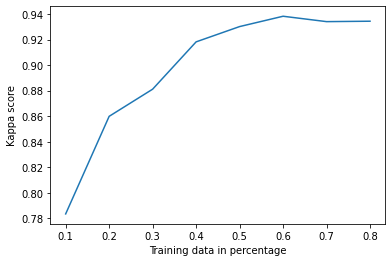

In [22]:
train_data_per = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
kappa_score = np.array(list(kappa_score.items())).T[1]
plt.plot(train_data_per,kappa_score)
plt.xlabel('Training data in percentage')
plt.ylabel('Kappa score')
plt.show()